<a href="https://colab.research.google.com/github/Kedar154/AI-Driven-Stock-Market-Intelligence/blob/main/stock_pred_ARIMA_GARCH_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/vijayvvenkitesh/microsoft-stock-time-series-analysis')

Skipping, found downloaded files in "./microsoft-stock-time-series-analysis" (use force=True to force download)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy.stats import boxcox

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
data = pd.read_csv('/content/microsoft-stock-time-series-analysis/Microsoft_Stock.csv')

In [5]:
pip install arch

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

In [7]:
data

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012


In [8]:
stock = pd.DataFrame()
stock['prices'] = data['Close']
stock['date'] = pd.to_datetime(data['Date']).dt.date
stock.set_index('date', inplace=True)
stock.sort_index(inplace=True)
stock.head()

,prices
date,
2015-04-01,40.72
2015-04-02,40.29
2015-04-06,41.55
2015-04-07,41.53
2015-04-08,41.42


In [9]:
stock['log_prices'] = np.log(stock['prices'])
stock.head()

,prices,log_prices
date,,
2015-04-01,40.72,3.706719
2015-04-02,40.29,3.696103
2015-04-06,41.55,3.726898
2015-04-07,41.53,3.726416
2015-04-08,41.42,3.723764


In [10]:
stock['log_return'] = np.log(stock['prices']).diff()*100
stock.dropna(inplace = True)

In [11]:
# 1. Ensure the index is Datetime
stock.index = pd.to_datetime(stock.index)

# 2. Reindex to Business Days ('B')
# This adds the missing weekend/holiday rows as NaN
stock = stock.asfreq('B')

# 3. Fill the gaps
# Option A: Your idea (Arithmetic mean of neighbors)
stock['prices'] = stock['prices'].interpolate(method='linear')
stock['log_prices'] = stock['log_prices'].interpolate(method='linear')
# Option B: Financial standard (Carry last price forward)
# stock['prices'] = stock['prices'].ffill()

# 4. RE-CALCULATE Log Returns after filling
# You MUST do this because NaN prices create NaN returns
stock['log_return'] = 100 * np.log(stock['prices'] / stock['prices'].shift(1))
stock = stock.dropna() # Remove the very first row created by the shift

In [12]:
stock.isna().sum()

,0
prices,0
log_prices,0
log_return,0


## ADF TEST

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(stock.log_return)
print(f'ADF P-value: {result[1]}')

ADF P-value: 2.4043064867035405e-20


## visualising:

In [14]:
def graph(df, y, x_label, y_label, title):
  plt.figure(figsize=(10, 4))
  plt.plot(df.index, df[y])
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()

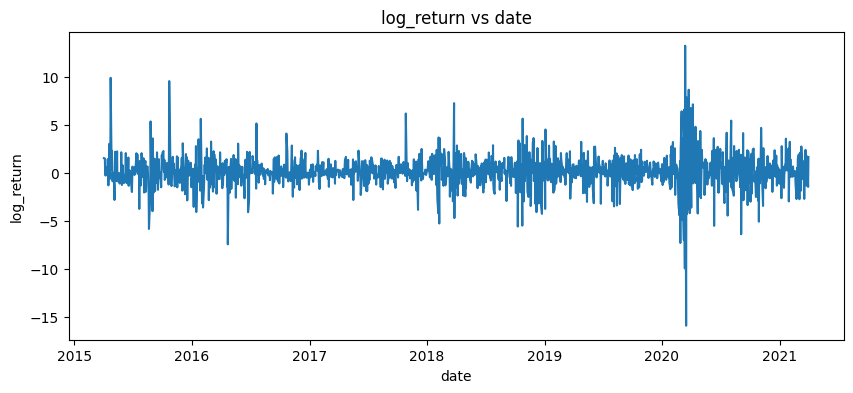

In [15]:
graph(stock, 'log_return', 'date', 'log_return', 'log_return vs date')

# PACF & ACF

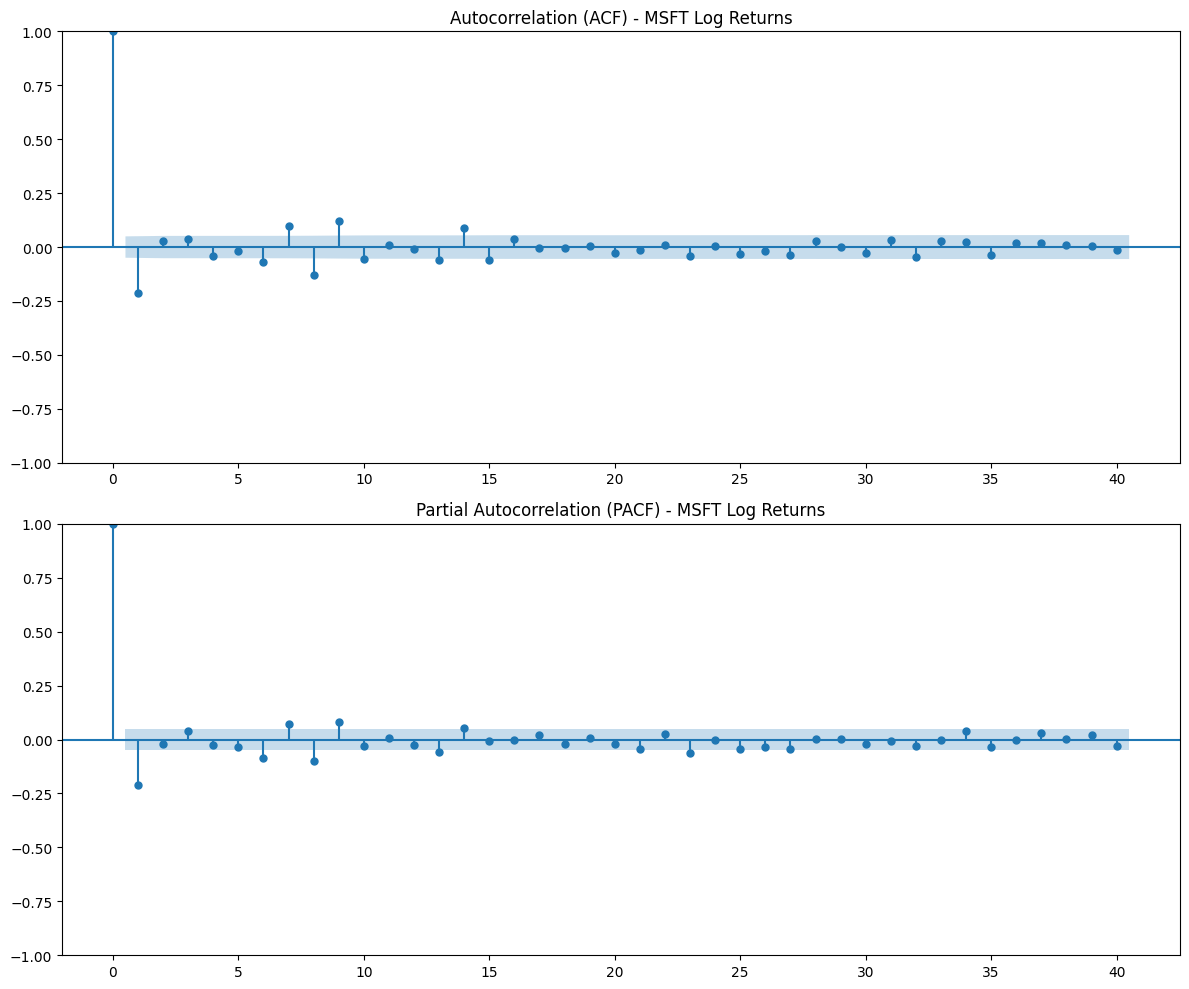

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set up a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot ACF (helps determine the 'q' or MA term)
# Lags=40 is a good default for daily stock data
plot_acf(stock.log_return, lags=40, ax=ax1)
ax1.set_title('Autocorrelation (ACF) - MSFT Log Returns')

# Plot PACF (helps determine the 'p' or AR term)
plot_pacf(stock.log_return, lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation (PACF) - MSFT Log Returns')

plt.tight_layout()
plt.show()

# TTS

In [17]:
tr = stock.iloc[:int(0.8*len(stock))]
val = stock.iloc[int(0.8*len(stock)):int(.85*len(stock))]
test = stock.iloc[int(.85*len(stock)):]

## ARIMA

In [18]:
arima_model = ARIMA(tr.log_return, order=(8, 0, 8))
arima_result = arima_model.fit(cov_type= 'robust')

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
forecast_steps = 7

In [20]:
arima_pred = arima_result.forecast(steps=forecast_steps)

In [21]:
arima_pred


,predicted_mean
2020-01-20,-0.479603
2020-01-21,0.212752
2020-01-22,0.190030
2020-01-23,-0.079307
2020-01-24,0.045209
2020-01-27,-0.126423
2020-01-28,0.343442


In [22]:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log_return   No. Observations:                 1251
Model:                 ARIMA(8, 0, 8)   Log Likelihood               -2176.089
Date:                Sun, 18 Jan 2026   AIC                           4388.179
Time:                        13:08:40   BIC                           4480.549
Sample:                    04-03-2015   HQIC                          4422.902
                         - 01-17-2020                                         
Covariance Type:               robust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1136      0.032      3.524      0.000       0.050       0.177
ar.L1         -0.0041      0.141     -0.029      0.977      -0.281       0.273
ar.L2         -0.1388      0.120     -1.157      0.247      -0.374       0.096
ar.L3         -0.0096      0.110     -0.087      0.931      -0.226       0.206
ar.L4          0.6119      0.111      5.523      0.000       0.395       0.829
ar.L5          0.2592      0.113      2.290      0.022       0.037       0.481
ar.L6         -0.2643      0.129     -2.052      0.040      -0.517      -0.012
ar.L7          0.0916      0.117      0.784      0.433      -0.137       0.321
ar.L8         -0.6860      0.108     -6.354      0.000      -0.898      -0.474
ma.L1         -0.0655      0.150     -0.438      0.661      -0.359       0.228
ma.L2          0.0623      0.129      0.484      0.628      -0.190       0.314
ma.L3         -0.0007      0.116     -0.006      0.995      -0.229       0.227
ma.L4         -0.6240      0.111     -5.613      0.000      -0.842      -0.406
ma.L5         -0.2852      0.114     -2.502      0.012      -0.509      -0.062
ma.L6          0.3411      0.129      2.653      0.008       0.089       0.593
ma.L7         -0.1126      0.130     -0.868      0.385      -0.367       0.142
ma.L8          0.6295      0.120      5.246      0.000       0.394       0.865
sigma2         1.9051      0.153     12.447      0.000       1.605       2.205
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              1992.31
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             0.21
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.17
===================================================================================

Warnings:
[1] Quasi-maximum likelihood covariance matrix used for robustness to some misspecifications; calculated using the observed information matrix (complex-step) described in Harvey (1989).
"""

## GARCH

In [23]:
garch_model = arch_model(arima_result.resid, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')

In [24]:
garch_vol = garch_result.forecast(horizon=forecast_steps)

In [25]:
garch_vol

## Retrieving Prediction

### ARIMA

In [26]:
last_price = tr.prices.iloc[-1]

# Calculate the cumulative price path
# np.cumsum adds the predicted returns together to project into the future
predicted_price_path = last_price * np.exp(np.cumsum(arima_pred)/100)

In [27]:
print(predicted_price_path)

2020-01-20    166.300502
2020-01-21    166.654686
2020-01-22    166.971682
2020-01-23    166.839315
2020-01-24    166.914758
2020-01-27    166.703873
2020-01-28    167.277388
Freq: B, Name: predicted_mean, dtype: float64


### GARCH

In [28]:
predicted_std = np.sqrt(garch_vol.variance.values[-1])/100
days = np.arange(1, 8)
sigma_t = predicted_std * np.sqrt(days)

### Confidence Band

In [29]:
upper_bound = predicted_price_path* np.exp(+ 1.96 * sigma_t)
lower_bound = predicted_price_path* np.exp(- 1.96 * sigma_t)

In [30]:
print(upper_bound)
print(lower_bound)

2020-01-20    170.410553
2020-01-21    172.675495
2020-01-22    174.561654
2020-01-23    175.795324
2020-01-24    177.123702
2020-01-27    178.054210
2020-01-28    179.750088
Freq: B, Name: predicted_mean, dtype: float64
2020-01-20    162.289580
2020-01-21    160.843809
2020-01-22    159.711723
2020-01-23    158.339576
2020-01-24    157.294230
2020-01-27    156.077081
2020-01-28    155.670158
Freq: B, Name: predicted_mean, dtype: float64


## ERROR

In [31]:
# Extract actuals and predictions
y_true = val['prices'].iloc[:7].values
y_pred = predicted_price_path  # Your 7-day predicted dollar prices

# Calculate Mean Absolute Percentage Error
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"7-Day MAPE: {mape:.2f}%")
print(f"Model Accuracy: {100 - mape:.2f}%")

7-Day MAPE: 0.88%
Model Accuracy: 99.12%


## PLOT

getting dates

In [32]:
last_date = tr.index[-1]
# 2. Create the next 7 business days
# We start from 'last_date' and take 8 periods, then skip the first one
# to ensure we start exactly one trading day after the training data ends.
forecast_dates = pd.date_range(start=last_date, periods=8, freq='B')[1:]

print(forecast_dates)

DatetimeIndex(['2020-01-20', '2020-01-21', '2020-01-22', '2020-01-23',
               '2020-01-24', '2020-01-27', '2020-01-28'],
              dtype='datetime64[ns]', freq='B')


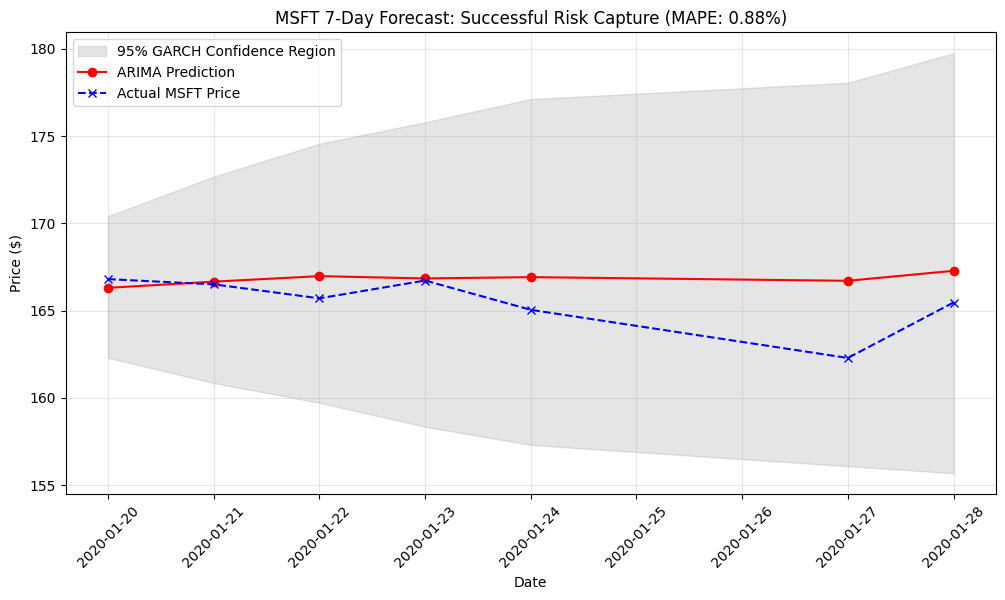

In [33]:
import matplotlib.pyplot as plt

# 1. Create the plot
plt.figure(figsize=(12, 6))

# 2. Plot the 'Risk Cone' using your new bounds
plt.fill_between(forecast_dates, lower_bound, upper_bound,
                 color='gray', alpha=0.2, label='95% GARCH Confidence Region')

# 3. Plot your Predicted Mean (the fixed one around 166-167)
plt.plot(forecast_dates, predicted_price_path, color='red', marker='o', label='ARIMA Prediction')

# 4. Plot the Actual Prices (the 165-168 range)
plt.plot(forecast_dates, y_true, color='blue', marker='x', linestyle='--', label='Actual MSFT Price')

# 5. Formatting
plt.title(f"MSFT 7-Day Forecast: Successful Risk Capture (MAPE: {mape:.2f}%)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

In [34]:
actual_7_days = val['prices'].iloc[:7]
print(actual_7_days)

date
2020-01-20    166.80
2020-01-21    166.50
2020-01-22    165.70
2020-01-23    166.72
2020-01-24    165.04
2020-01-27    162.28
2020-01-28    165.46
Freq: B, Name: prices, dtype: float64


## Residual Check

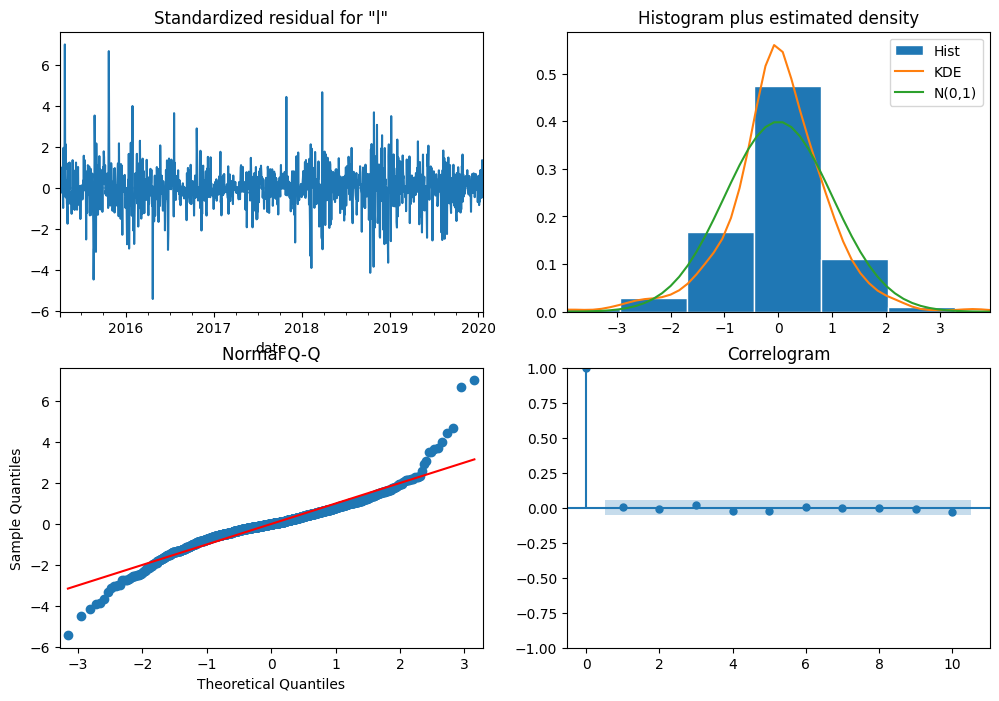

In [35]:
# 1. Get the residuals
residuals = arima_result.resid

# 2. Plot the diagnostics
arima_result.plot_diagnostics(figsize=(12, 8))
plt.show()

plotting past days

In [36]:
# --- 1. PREPARE HISTORICAL FIT (Past 30 Days) ---
past_dates = tr.index[-30:]
past_actuals = tr['prices'].iloc[-30:]

# One-step-ahead prediction: Use (Actual Price at t-1) * exp(Predicted Return at t)
# This shows how well the model "hugs" the real data
prev_prices = tr['prices'].iloc[-31:-1].values
past_preds = prev_prices * np.exp(arima_result.fittedvalues[-30:] / 100)
past_preds

,0
date,
2019-12-09,152.045161
2019-12-10,151.652927
2019-12-11,151.605410
2019-12-12,151.742200
2019-12-13,153.608336
2019-12-16,154.156451
2019-12-17,155.651374
2019-12-18,154.685124
2019-12-19,154.517759


## Static forecast

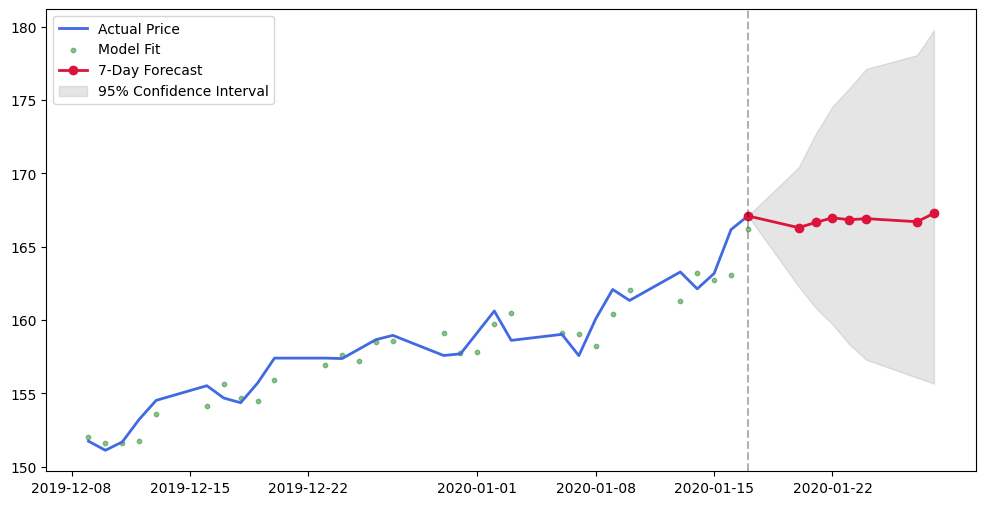

In [37]:
# --- 1. THE "BRIDGE" ---
# We add the very last historical data point to the front of our forecast
# This ensures the lines physically touch on the graph
bridge_date = [past_dates[-1]]
bridge_price = [past_actuals.iloc[-1]]

# Combine bridge with forecast for plotting
full_forecast_dates = pd.to_datetime(bridge_date + list(forecast_dates))
full_predicted_path = np.concatenate([bridge_price, predicted_price_path])
full_lower = np.concatenate([bridge_price, lower_bound])
full_upper = np.concatenate([bridge_price, upper_bound])

# --- 2. THE PLOT ---
plt.figure(figsize=(12, 6))

# Historical Actual (The Blue Line)
plt.plot(past_dates, past_actuals, color='royalblue', label='Actual Price', linewidth=2)

# Model Fit (The Green Dots - In-Sample)
plt.scatter(past_dates, past_preds, color='forestgreen', s=10, label='Model Fit', alpha=0.5)

# 7-Day Future Projection (The Red Line - Connected)
plt.plot(full_forecast_dates, full_predicted_path, color='crimson', marker='o', label='7-Day Forecast', linewidth=2)

# Shaded Confidence Interval (Stitched to the start)
plt.fill_between(full_forecast_dates, full_lower, full_upper, color='gray', alpha=0.2, label='95% Confidence Interval')

plt.axvline(x=past_dates[-1], color='black', linestyle='--', alpha=0.3) # Clear divider
plt.legend()
plt.show()

In [38]:
tr

,prices,log_prices,log_return
date,,,
2015-04-03,40.92,3.711500,1.551564
2015-04-06,41.55,3.726898,1.527858
2015-04-07,41.53,3.726416,-0.048146
2015-04-08,41.42,3.723764,-0.265220
2015-04-09,41.48,3.725211,0.144753
...,...,...,...
2020-01-13,163.28,5.095467,1.195258
2020-01-14,162.13,5.088398,-0.706804
2020-01-15,163.18,5.094854,0.645540


In [39]:
# --- 1. SETUP ---
history = list(tr['log_return']) # Start with all training data
actual_test_returns = val['log_return'].iloc[:7] # The real returns for the 7 days
rolling_predictions = []

# --- 2. THE ROLLING LOOP ---
# We predict 1 step, then add the REAL data point to 'history' and repeat
for t in range(len(actual_test_returns)):
    # Fit model on the current 'history'
    model = ARIMA(history, order=(8, 0, 8))
    model_fit = model.fit()

    # Predict the NEXT day only
    yhat = model_fit.forecast(steps=1)[0]
    rolling_predictions.append(yhat)

    # Observe the actual price and add it to history for the next loop
    obs = actual_test_returns.iloc[t]
    history.append(obs)

# --- 3. CONVERT BACK TO PRICE ---
# Use the actual last price from training as the starting point
last_price = tr['prices'].iloc[-1]
# Calculate price path step-by-step
rolling_prices = []
current_price = last_price

for ret in rolling_predictions:
    current_price = current_price * np.exp(ret / 100)
    rolling_prices.append(current_price)

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

rolling forecast: arima + garch

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels

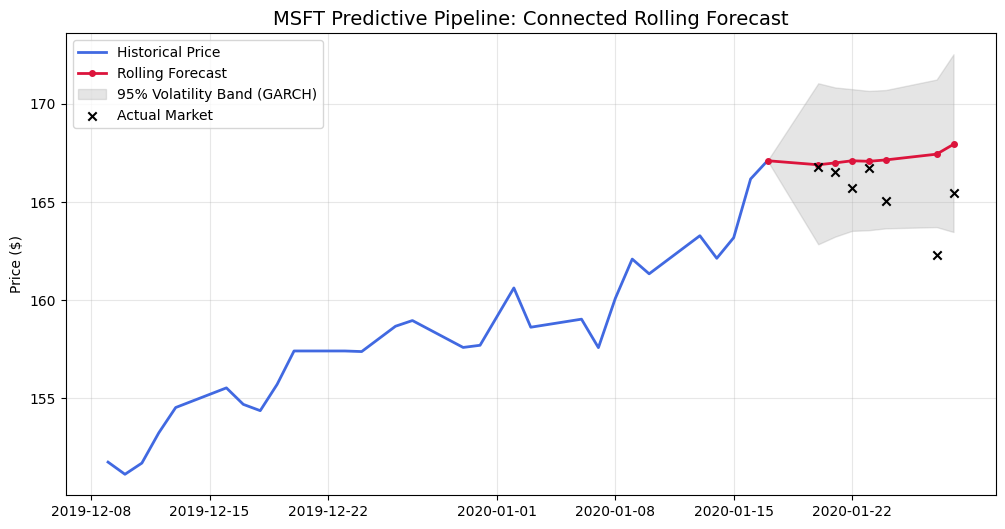

In [40]:
# --- 1. THE ROLLING LOOP (ARIMA + GARCH) ---
history_ret = list(tr['log_return'])
rolling_prices = []
lower_bounds = []
upper_bounds = []

current_price = tr['prices'].iloc[-1]

for t in range(7):
    # Fit ARIMA
    model = ARIMA(history_ret, order=(5, 0, 5))
    model_fit = model.fit()
    pred_ret = model_fit.forecast(steps=1)[0]

    # Fit GARCH on the residuals to get tomorrow's volatility
    # Note: Using the last predicted volatility for the bound
    garch = arch_model(model_fit.resid, vol='Garch', p=1, q=1)
    garch_fit = garch.fit(disp='off')
    pred_vol = np.sqrt(garch_fit.forecast(horizon=1).variance.values[-1, 0])

    # Calculate predicted price
    current_price = current_price * np.exp(pred_ret / 100)
    rolling_prices.append(current_price)

    # Calculate 95% Confidence Interval (1.96 standard deviations)
    # These are log-return bounds converted back to price
    lower_bounds.append(current_price * np.exp(-1.96 * pred_vol / 100))
    upper_bounds.append(current_price * np.exp(1.96 * pred_vol / 100))

    # Roll forward: add the REAL data point to history for the next iteration
    history_ret.append(val['log_return'].iloc[t])

# --- 2. THE BRIDGE (Stitching the Gap) ---
# We start the forecast line at the last actual price
bridge_date = [tr.index[-1]]
bridge_price = [tr['prices'].iloc[-1]]

plot_dates = pd.to_datetime(bridge_date + list(forecast_dates))
plot_prices = np.concatenate([bridge_price, rolling_prices])
plot_lower = np.concatenate([bridge_price, lower_bounds])
plot_upper = np.concatenate([bridge_price, upper_bounds])

# --- 3. THE PLOT ---
plt.figure(figsize=(12, 6))

# Historical (Blue)
plt.plot(tr.index[-30:], tr['prices'].iloc[-30:],
         color='royalblue', label='Historical Price', linewidth=2)

# Rolling Forecast (Red Line - now connected)
plt.plot(plot_dates, plot_prices, color='crimson', marker='o',
         markersize=4, label='Rolling Forecast', linewidth=2)

# Grey Band (Dynamic Confidence Interval)
plt.fill_between(plot_dates, plot_lower, plot_upper, color='gray',
                 alpha=0.2, label='95% Volatility Band (GARCH)')

# Market Reality (Black X's)
plt.scatter(forecast_dates, val['prices'].iloc[:7],
            color='black', marker='x', label='Actual Market', zorder=5)

plt.title("MSFT Predictive Pipeline: Connected Rolling Forecast", fontsize=14)
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

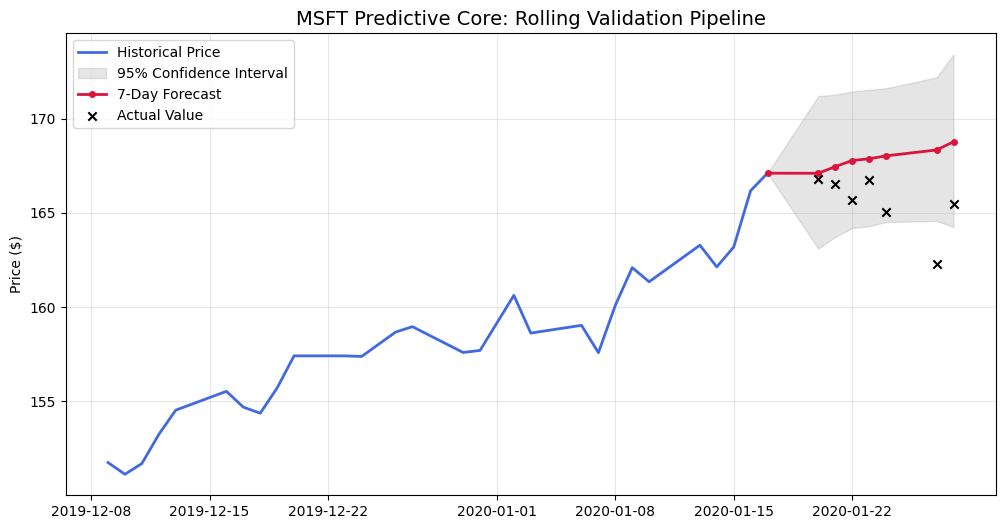

In [46]:
# --- 1. THE ROLLING LOOP (ARIMA + GARCH) ---
history_ret = list(tr['log_return'])
rolling_prices = []
lower_bounds = []
upper_bounds = []

# Start from the very last price in your training set (tr)
current_price = tr['prices'].iloc[-1]

for t in range(7):
    # Fit ARIMA on returns
    model = ARIMA(history_ret, order=(2, 0, 2))
    model_fit = model.fit(cov_type = 'robust')
    pred_ret = model_fit.forecast(steps=1)[0]

    # Fit GARCH to get the "Grey Band" width
    garch = arch_model(model_fit.resid, vol='Garch', p=1, q=1)
    garch_fit = garch.fit(disp='off')
    # Get 1-step ahead standard deviation (volatility)
    pred_vol = np.sqrt(garch_fit.forecast(horizon=1).variance.values[-1, 0])

    # Calculate predicted price for this step
    current_price = current_price * np.exp(pred_ret / 100)
    rolling_prices.append(current_price)

    # Calculate 95% Confidence Interval (1.96 * sigma)
    lower_bounds.append(current_price * np.exp(-1.96 * pred_vol / 100))
    upper_bounds.append(current_price * np.exp(1.96 * pred_vol / 100))

    # IMPORTANT: Update history with the ACTUAL return from val to "roll" forward
    history_ret.append(val['log_return'].iloc[t])

# --- 2. THE BRIDGE (Connecting the dots) ---
# This ensures the red line starts EXACTLY at the end of the blue line
# Corrected: Ensure full_dates is a proper DatetimeIndex for matplotlib
full_dates = pd.to_datetime(np.concatenate([[tr.index[-1]], val.index[:7]]))
full_path = np.concatenate([[tr['prices'].iloc[-1]], rolling_prices])
full_low = np.concatenate([[tr['prices'].iloc[-1]], lower_bounds])
full_up = np.concatenate([[tr['prices'].iloc[-1]], upper_bounds])

# --- 3. THE PLOT ---
plt.figure(figsize=(12, 6))

# Historical (Blue) - last 30 days
plt.plot(tr.index[-30:], tr['prices'].iloc[-30:],
         color='royalblue', label='Historical Price', linewidth=2)

# Grey Band (Confidence Interval)
plt.fill_between(full_dates, full_low, full_up, color='gray', alpha=0.2, label='95% Confidence Interval')

# Rolling Forecast (Red Line)
plt.plot(full_dates, full_path, color='crimson', marker='o', markersize=4, label='7-Day Forecast', linewidth=2)

# Actual Market Value (Black X)
plt.scatter(val.index[:7], val['prices'].iloc[:7], color='black', marker='x', label='Actual Value', zorder=5)

plt.title("MSFT Predictive Core: Rolling Validation Pipeline", fontsize=14)
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

alternate line

In [42]:
# 1. Ensure the index is Datetime
#tr.index = pd.to_datetime(tr.index)

# 2. Reindex to Business Days ('B')
# This adds the missing weekend/holiday rows as NaN
#tr = tr.asfreq('B')

# 3. Fill the gaps
# Option A: Your idea (Arithmetic mean of neighbors)
#tr['prices'] = tr['prices'].interpolate(method='linear')
#tr['log_prices'] = tr['log_prices'].interpolate(method='linear')
# Option B: Financial standard (Carry last price forward)
# tr['prices'] = tr['prices'].ffill()

# 4. RE-CALCULATE Log Returns after filling
# You MUST do this because NaN prices create NaN returns
#tr['log_return'] = 100 * np.log(tr['prices'] / tr['prices'].shift(1))
#tr = tr.dropna() # Remove the very first row created by the shift

In [43]:
tr.isna().sum()

,0
prices,0
log_prices,0
log_return,0


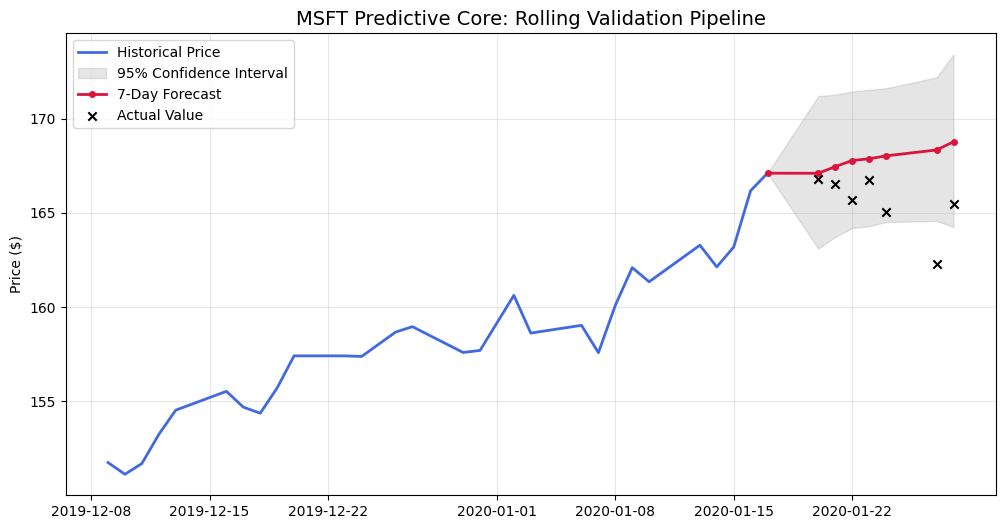

In [48]:
# --- 1. THE ROLLING LOOP (ARIMA + GARCH) ---
history_ret = list(tr['log_return'])
rolling_prices = []
lower_bounds = []
upper_bounds = []

# Start from the very last price in your training set (tr)
current_price = tr['prices'].iloc[-1]

for t in range(7):
    # Fit ARIMA on returns
    model = ARIMA(history_ret, order=(2, 0, 2))
    model_fit = model.fit(cov_type = 'robust')
    pred_ret = model_fit.forecast(steps=1)[0]

    # Fit GARCH to get the "Grey Band" width
    garch = arch_model(model_fit.resid, vol='Garch', p=1, q=1)
    garch_fit = garch.fit(disp='off')
    # Get 1-step ahead standard deviation (volatility)
    pred_vol = np.sqrt(garch_fit.forecast(horizon=1).variance.values[-1, 0])

    # Calculate predicted price for this step
    current_price = current_price * np.exp(pred_ret / 100)
    rolling_prices.append(current_price)

    # Calculate 95% Confidence Interval (1.96 * sigma)
    lower_bounds.append(current_price * np.exp(-1.96 * pred_vol / 100))
    upper_bounds.append(current_price * np.exp(1.96 * pred_vol / 100))

    # IMPORTANT: Update history with the ACTUAL return from val to "roll" forward
    history_ret.append(val['log_return'].iloc[t])

# --- 2. THE BRIDGE (Connecting the dots) ---
# This ensures the red line starts EXACTLY at the end of the blue line
# Corrected: Ensure full_dates is a proper DatetimeIndex for matplotlib
full_dates = pd.to_datetime(np.concatenate([[tr.index[-1]], val.index[:7]]))
full_path = np.concatenate([[tr['prices'].iloc[-1]], rolling_prices])
full_low = np.concatenate([[tr['prices'].iloc[-1]], lower_bounds])
full_up = np.concatenate([[tr['prices'].iloc[-1]], upper_bounds])

# --- 3. THE PLOT ---
plt.figure(figsize=(12, 6))

# Historical (Blue) - last 30 days
plt.plot(tr.index[-30:], tr['prices'].iloc[-30:],
         color='royalblue', label='Historical Price', linewidth=2)

# Grey Band (Confidence Interval)
plt.fill_between(full_dates, full_low, full_up, color='gray', alpha=0.2, label='95% Confidence Interval')

# Rolling Forecast (Red Line)
plt.plot(full_dates, full_path, color='crimson', marker='o', markersize=4, label='7-Day Forecast', linewidth=2)

# Actual Market Value (Black X)
plt.scatter(val.index[:7], val['prices'].iloc[:7], color='black', marker='x', label='Actual Value', zorder=5)

plt.title("MSFT Predictive Core: Rolling Validation Pipeline", fontsize=14)
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()